<font color="#CC3D3D"><p>
# ML Case Study #1

- **`PROBLEM`**: 백화점 고객이 1년 동안 상품을 구매한 속성을 분석하여 `고객의 성별(0:여자, 1:남자)을 예측`하시오.
- **`INPUT`**: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- **`OUTPUT`**: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [4]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from bayes_opt import BayesianOptimization
import lightgbm as lgbm

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate
# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### 1. Read Data

In [5]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv('X_train.csv', encoding='cp949')
test = pd.read_csv('X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85
...,...,...,...,...,...,...,...,...,...
5977,82581500,23976000,NaN,골프,부산본점,8,1.750000,0.642857,40
5978,480000,480000,NaN,섬유잡화,광주점,1,1.000000,0.000000,0
5979,260003790,25750000,NaN,남성 캐주얼,본 점,19,3.736842,0.915493,18
5980,88991520,18120000,NaN,육류,본 점,5,3.600000,0.444444,60


### 2. EDA

In [6]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

### 3. Data Cleansing & Feature Engineering

In [7]:
# 범주형 변수와 수치형 변수를 분리

cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

*Impute Missing Values*

In [8]:
#구매상품을 분류 별로 나눈 것
#features['주구매상품1']=features['주구매상품'].apply(lambda x: '음식' if (x == '가공식품' or x == '건강식품' or 
#                                                                                               x == '농산물' or x == '수산품' or x == '육류' or 
#                                                                                               x == '젓갈/반찬' or x == '축산가공') 
#                                          else '물품' if (x == '가구' or x == '대형가전'  or x == '생활잡화' or 
#                                                                                        x == '소형가전' or x == '식기' or x == '일용잡화' or x == '주방가전' or
#                                                                                          x == '주방용품' or x=='침구/수예')
#                                           else '남성성' if (x == '골프' or x == '구두'  or x == '남성 캐주얼' or 
#                                                                                         x == '남성 트랜디' or x == '남성정장' or x == '셔츠' or x == '스포츠' or
#                                                                                         x == '시티웨어' or x=='통신/컴퓨터' or x== '주류' or x=='트래디셔널')
#                                           else '여성성' if (x == '디자이너' or x == '란제리/내의'  or x == '섬유잡화' or 
#                                                                                         x == '캐주얼' or x == '명품' or x == '모피/피혁' or x == '보석' or
#                                                                                          x == '액세서리' or x=='피혁잡화' or x== '화장품')
#                                           else '기타')

In [9]:
#지역별로 주매지점을 나눈 것
#features['주구매지점1']=features['주구매지점'].apply(lambda x: '서울' if (x == '잠실점' or x == '영등포점' or 
#                                                                                               x == '강남점' or x == '청량리점' or x == '노원점' or 
#                                                                                               x == '미아점' or x == '관악점') 
#                                          else '경기도' if (x == '분당점' or x == '일산점'  or x == '인천점' )
#                                         else '타지역' if (x == '부산본점' or x == '광주점'  or x == '대전점' or 
#                                                                                         x == '동래점' or x == '울산점' or x == '센텀시티점' or x == '창원점'
#                                                                                          or x=='포항점' or x== '대구점' or x=='전주점'or x=='상인점')
#                                         else '본점' if (x == '본  점')
#                                          else '매각점')

In [10]:
##서울을 따로 만든것
#features['서울지점']=features['주구매지점'].apply(lambda x: '서울' if (x == '잠실점' or x == '영등포점' or 
#                                                                                               x == '강남점' or x == '청량리점' or x == '노원점' or 
#                                                                                               x == '미아점' or x == '관악점') else '나머지')

In [11]:
##경기도을 따로 만든것
#features['경기도지점']=features['주구매지점'].apply(lambda x: '경기도' if (x == '분당점' or x == '일산점'  or x == '인천점' ) else '나머지')

In [12]:
##지방을 따로 만든것
#features['지방지점']=features['주구매지점'].apply(lambda x: '타지역' if (x == '부산본점' or x == '광주점'  or x == '대전점' or 
 #                                                                                         x == '동래점' or x == '울산점' or x == '센텀시티점' or x == '창원점'
  #                                                                                        or x=='포항점' or x== '대구점' or x=='전주점'or x=='상인점') else '나머지')

In [13]:
##본지점을 따로 만든것
#features['본지점']=features['주구매지점'].apply(lambda x:'본점' if (x == '본  점') else '나머지')

In [14]:
##매각을 한 지점을 따로 만든것
#features['매각지점']=features['주구매지점'].apply(lambda x:'매각지점' if (x == '안양점' or x == '부평점') else '나머지')

In [15]:
##롯데백화점 데이터로 지점 별 등급이 높은 에비뉴엘을 나눈 것
#features['에비뉴엘']=features['주구매지점'].apply(lambda x: '에비뉴엘' if (x=='본  점' or x=='잠실점' or x=='부산본점')
#                                         else '노 에비뉴엘')

In [16]:
#남자제품을 따로 뽑은 것
features['남자제품']=features['주구매상품'].apply(lambda x: '남성' if (x == '골프'  or x == '남성 캐주얼' or 
                                                                                          x == '남성 트랜디' or x == '남성정장' or x == '셔츠' or x == '스포츠' or
                                                                                          x == '시티웨어' or x=='통신/컴퓨터' or x== '주류' or x=='트래디셔널')
                                         else '나머지')

In [17]:
#여자제품을 따로 뽑은 것
features['여자제품']=features['주구매상품'].apply(lambda x: '여자' if (x == '명품' or x == '화장품'  or x == '액세서리' or 
                                                                                         x == '피혁잡화' or x == '모피/피혁' or x == '란제리/내의') 
                                           else '나머지')

In [18]:
#총구매액으로 고객 등급을 나눈 것, 롯데백화점 사이트의 등급을 실제로 이용
features['고객등급']=features['총구매액'].apply(lambda x:'AVENUEL' if (x>200000000) else 'LENITH' if (x>100000000)else 'MVG-Prestige' if (x >60000000)
                                                                   else 'MVG-Crown' if (x >40000000)
                                        else 'VIP+' if (x >8000000)
                                                                   else 'VIP' if (x >4000000) else '일반')

meanencoding 을 이용하여 주구매상품과 주구매지점에 대한 열을 따로 새로 만들어 줌

In [19]:
train_1=train.copy()
train_1['성별']=y_train

In [20]:
mean=train_1['성별'].mean()
agg=train_1.groupby('주구매상품')['성별'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
features['상품_mean']=features['주구매상품'].map(smooth)

In [21]:
mean=train_1['성별'].mean()
agg=train_1.groupby('주구매지점')['성별'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
features['지점_mean']=features['주구매지점'].map(smooth)

In [22]:
# 결측값 처리: 범주형이냐 수치형이냐에 따라 다르게 처리
# 현재 결측값은 환불금액만 있기 때문에 일단 미뤄두고 진행하겠다.

if len(num_features) > 0: 
    features[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(features[num_features])
if len(cat_features) > 0:  
    features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])

features.isnull().sum()

총구매액       0
최대구매액      0
환불금액       0
주구매상품      0
주구매지점      0
내점일수       0
내점당구매건수    0
주말방문비율     0
구매주기       0
남자제품       0
여자제품       0
고객등급       0
상품_mean    0
지점_mean    0
dtype: int64

--- 내점당구매건수* 내점일수 = 총구매건수

In [23]:
features['총구매건수']=features['내점일수']*features['내점당구매건수']

총구매액과 총구매건수를 곱하여 건평균구매액을 만든것

In [24]:
features['건평균구매액']=features['총구매액']*features['총구매건수']

구매주기와 내점일수를 이용하여 생활기간을 만든 것

In [25]:
features['생활기간']=features['구매주기']*features['내점일수']

총구매액과 환불금액을 이용하여 비환불금액을 만든 것

In [26]:
features['비환불금액']=features['총구매액']-features['환불금액']

비환불금액과 총구매건수를 이용하여 구매상품평균금액을 만들

In [27]:
features['구매상품평균금액']=features['비환불금액']*features['총구매건수']

구매주기를 이용하여 구매왕과 아닌 것을 나눈 것

In [28]:
features[features['구매주기']>100]
features['구매주기_1']=features['구매주기'].apply(lambda x: '구매왕' if x>100 else '나머지')

음의 수를 log1p를 하기 위해 0으로 바꿔준 것

In [29]:
features['총구매액']=features['총구매액'].apply(lambda x: 0 if x<0 else x)
features['최대구매액']=features['최대구매액'].apply(lambda x: 0 if x<0 else x)
features['환불금액']=features['환불금액'].apply(lambda x: 0 if x<0 else x)
features['건평균구매액']=features['건평균구매액'].apply(lambda x: 0 if x<0 else x)
features['구매상품평균금액']=features['구매상품평균금액'].apply(lambda x: 0 if x<0 else x)

로그변환을 사용해줌 log1p를 이용

In [30]:
features['총구매액']=np.log1p(features['총구매액']) 
features['최대구매액']=np.log1p(features['최대구매액']) 
features['환불금액']=np.log1p(features['환불금액']) 
features['건평균구매액']=np.log1p(features['건평균구매액']) 
features['구매상품평균금액']=np.log1p(features['구매상품평균금액'])

In [31]:
features['최대구매액']=np.log1p(features['최대구매액']) 
features['환불금액']=np.log1p(features['환불금액']) 
features['건평균구매액']=np.log1p(features['건평균구매액'])

*Deal with Outliers*

In [32]:
# 범주형 변수와 수치형 변수를 분리

cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

meanencoding 을 이용한 열제외하고 이상치 처리

In [33]:
num_features.remove('상품_mean')
num_features.remove('지점_mean')

In [34]:
# 수치형 변수에 대해 이상치(outlier)를 처리
features[num_features] = features[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

In [33]:
#for col in ['총구매액', '최대구매액', '환불금액', '건평균구매액', '구매상품평균금액']:
#    features[col] = np.log2(1 + features[col])

In [34]:
#for col in ['최대구매액', '환불금액', '건평균구매액']:
#    features[col] = np.log2(1 + features[col])

standardscaler 를 이용하여 스케일링을 해준 것

In [35]:
#num_features-['주말방문비율','구매주기','생활기간']
num_features.remove('주말방문비율')
num_features.remove('구매주기')
num_features.remove('생활기간')

In [36]:
scaler = StandardScaler()
features[num_features] = scaler.fit_transform(features[num_features])

In [37]:
num_features.append('주말방문비율')
num_features.append('구매주기')
num_features.append('생활기간')
num_features.append('상품_mean')
num_features.append('지점_mean')

polynomial 을 이용하려 하였으나 효능이 좋지 않아 제외시켰음

In [40]:
#train_features=features.loc[:3499,num_features]
#test_features=features.loc[3500:,num_features]

In [41]:
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(2, include_bias=True)

In [42]:
#train_features = poly.fit_transform(train_features)
#test_features = poly.transform(test_features)

In [43]:
#train_features=pd.DataFrame(data=train_features, columns=poly.get_feature_names())

In [44]:
#test_features=pd.DataFrame(data=test_features, columns=poly.get_feature_names())

In [45]:
#features_num=pd.concat([train_features, test_features], axis=0,ignore_index=True)

In [46]:
#features_num[features_num.columns]

In [47]:
#scaler = StandardScaler()
#features_num[features_num.columns] = scaler.fit_transform(features_num[features_num.columns])

In [48]:
#features = pd.concat([features_num,features[['지점_mean','상품_mean']], pd.get_dummies(features[cat_features])], axis=1)
#features#

결합시킨거

In [38]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합

features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
features

,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,총구매건수,건평균구매액,비환불금액,구매상품평균금액,주말방문비율,...,여자제품_여자,고객등급_AVENUEL,고객등급_LENITH,고객등급_MVG-Crown,고객등급_MVG-Prestige,고객등급_VIP,고객등급_VIP+,고객등급_일반,구매주기_1_구매왕,구매주기_1_나머지
0,0.566538,0.293396,1.378200,0.056816,0.872291,0.249115,0.737943,-0.146959,0.722768,0.527027,...,0,0,0,0,1,0,0,0,0,1
1,-1.111230,-0.739928,1.223488,-0.753769,-0.872757,-0.701238,-1.164787,-0.702866,-1.125666,0.000000,...,0,0,0,0,0,0,0,1,0,1
2,-0.915946,-0.914654,-0.728331,-0.753769,-0.508406,-0.687853,-0.935191,-0.690168,-0.893827,0.000000,...,0,0,0,0,0,0,0,1,0,1
3,-0.133789,-0.206395,-0.728331,0.009135,-0.184539,-0.152443,0.240450,-0.570001,0.210753,0.318182,...,0,0,0,0,0,0,1,0,0,1
4,0.152685,0.730923,-0.728331,-0.753769,-0.872757,-0.701238,-0.342449,-0.448977,-0.365602,0.000000,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.658606,0.730357,-0.728331,-0.467680,-0.690582,-0.554000,0.368909,0.050437,0.345959,0.642857,...,0,0,0,0,1,0,0,0,0,1
5978,-1.834158,-1.766454,-0.728331,-0.801451,-1.237108,-0.728009,-1.955121,-0.715516,-1.797305,0.000000,...,0,0,0,0,0,0,0,1,0,1
5979,1.213989,0.770692,-0.728331,0.056816,0.757233,0.208960,1.043379,1.705672,1.108529,0.915493,...,0,1,0,0,0,0,0,0,0,1
5980,0.694806,0.570557,-0.728331,-0.610725,0.657516,-0.500459,0.452595,0.110239,0.435708,0.444444,...,0,0,0,0,1,0,0,0,0,1


## *Select Features*

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:55<00:00,  1.70it/s]


(29, 0.6884363141969262)


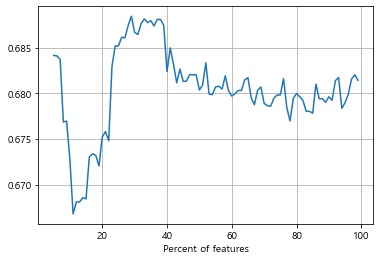

In [39]:
# 학습용과 제출용 데이터로 분리
features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
X_train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [40]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(3500, 27)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '총구매건수', '건평균구매액', '비환불금액', '구매상품평균금액', '주말방문비율', '생활기간', '상품_mean', '지점_mean', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_시티웨어', '주구매상품_주방가전', '주구매상품_화장품', '남자제품_나머지', '남자제품_남성', '여자제품_여자', '고객등급_AVENUEL', '고객등급_LENITH', '고객등급_VIP', '고객등급_일반']


### 4. Model Tuning (bayesianOptimization)

베이지안 옵티마이져를 다뤄본 것
사용하지는 않았음

In [41]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [42]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5) # 교차검증 시 남녀비율을 맞추기 위해 사용

RandomForest

In [265]:
def rand_evaluate(min_samples_leaf, maxDepth, max_features, colSam,nestimator,learningrate, output = 'score'):
    cla=RandomForestClassifier(max_depth= 2)
    scores = cross_val_score(cla, X_train, y_train, cv=5, scoring='roc_auc')
 
    if output == 'score' :
      return np.mean(scores)
    if output == 'model' :
      return cla
 
def bayesOpt(train_x, train_y):
    randBO = BayesianOptimization(rand_evaluate, { 'learningrate':(0.01,0.2), 'nestimator':(100,500),'min_samples_leaf':  (1,10),  'maxDepth': (2, 90),   'max_features': (17,34),   'colSam': (0.4, 1) })
    randBO.maximize(init_points=5, n_iter=30)
    print(randBO.res)
    return randBO

In [266]:
randBO = bayesOpt(X_train, y_train)

|   iter    |  target   |  colSam   | learni... | maxDepth  | max_fe... | min_sa... | nestim... |
-------------------------------------------------------------------------------------------------
|  1        |  0.6672   |  0.5927   |  0.1459   |  37.05    |  22.18    |  9.814    |  223.3    |
|  2        |  0.667    |  0.8909   |  0.1193   |  59.32    |  20.94    |  9.103    |  357.3    |
|  3        |  0.667    |  0.5129   |  0.1659   |  51.46    |  19.68    |  5.15     |  184.3    |
|  4        |  0.6688   |  0.973    |  0.06578  |  24.08    |  30.81    |  1.819    |  177.4    |
|  5        |  0.6699   |  0.7019   |  0.1965   |  27.63    |  22.42    |  9.391    |  392.8    |
|  6        |  0.6663   |  0.9336   |  0.1346   |  25.11    |  28.73    |  2.474    |  177.4    |
|  7        |  0.6681   |  0.8204   |  0.1229   |  65.32    |  31.6     |  2.66     |  312.5    |
|  8        |  0.6684   |  0.6605   |  0.1138   |  45.29    |  23.42    |  9.305    |  223.5    |
|  9        |  0.669

In [270]:
params_rand = randBO.max['params']
 
# 모델에 적용
model = rand_evaluate(
    learningrate=params_rand['learningrate'],
    nestimator=params_rand['nestimator'],
     maxDepth = params_rand['maxDepth'],
     colSam = params_rand['colSam'],
    min_samples_leaf=params_rand['min_samples_leaf'],
    max_features=params_rand['max_features'],
     output = 'model'
     )

In [271]:
params_rand

{'colSam': 0.9543719547617695,
 'learningrate': 0.149509361347902,
 'maxDepth': 79.4823613455046,
 'max_features': 26.327949408885424,
 'min_samples_leaf': 5.778115355848725,
 'nestimator': 383.5384930865464}

LGBMClassifier

In [241]:
def lgb_evaluate(numLeaves, maxDepth, scaleWeight, minChildWeight, subsample, colSam,nestimator,learningrate, output = 'score'):
    cla=lgb.LGBMClassifier(num_leaves=31, max_depth= 2,scale_pos_weight= scaleWeight, min_child_weight= minChildWeight, subsample= 0.4, colsample_bytree= 0.4)
    scores = cross_val_score(cla, X_train, y_train, cv=5, scoring='roc_auc')
    # scores = cross_val_score(reg, train_x, train_y, cv=5, scoring='neg_mean_squared_error')
 
    if output == 'score' :
      return np.mean(scores)
    if output == 'model' :
      return cla
 
def bayesOpt(train_x, train_y):
    lgbBO = BayesianOptimization(lgb_evaluate, { 'learningrate':(0.01,0.2), 'nestimator':(100,500),'numLeaves':  (5, 90),  'maxDepth': (2, 90),   'scaleWeight': (1, 10000),  'minChildWeight': (0.01, 70), 'subsample': (0.4, 1), 'colSam': (0.4, 1) })
    lgbBO.maximize(init_points=5, n_iter=30)
    print(lgbBO.res)
    return lgbBO

In [242]:
lgbBO = bayesOpt(X_train, y_train)

|   iter    |  target   |  colSam   | learni... | maxDepth  | minChi... | nestim... | numLeaves | scaleW... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.693    |  0.7456   |  0.03626  |  24.4     |  31.4     |  110.2    |  12.32    |  1.08e+03 |  0.6265   |
|  2        |  0.6959   |  0.5899   |  0.02393  |  67.38    |  2.259    |  381.5    |  58.57    |  1.145e+0 |  0.5061   |
|  3        |  0.6934   |  0.4135   |  0.02135  |  85.32    |  2.506    |  375.2    |  28.92    |  766.3    |  0.9209   |
|  4        |  0.6913   |  0.8375   |  0.03399  |  21.89    |  54.03    |  112.8    |  62.87    |  264.5    |  0.6149   |
|  5        |  0.6906   |  0.7103   |  0.07591  |  37.66    |  11.62    |  365.8    |  89.95    |  9.144e+0 |  0.5486   |
|  6        |  0.69     |  0.9692   |  0.1662   |  40.13    |  21.99    |  251.4    |  41.98    |  5.625e+0 |  0.4926   |
|  7        |  0.6905   

In [243]:
params_lgb = lgbBO.max['params']
 
# 모델에 적용
model = lgb_evaluate(
    learningrate=params_lgb['learningrate'],
    nestimator=params_lgb['nestimator'],
    numLeaves = params_lgb['numLeaves'],
     maxDepth = params_lgb['maxDepth'],
     scaleWeight = params_lgb['maxDepth'],
     minChildWeight = params_lgb['minChildWeight'],
     subsample = params_lgb['subsample'],
     colSam = params_lgb['colSam'],
     output = 'model'
     )

In [244]:
params_lgb

{'colSam': 0.5899345427049327,
 'learningrate': 0.023930536433008,
 'maxDepth': 67.3847264821173,
 'minChildWeight': 2.2592437085969928,
 'nestimator': 381.48036249258377,
 'numLeaves': 58.57403739538251,
 'scaleWeight': 1145.211831114847,
 'subsample': 0.506106176585304}

XGBClassifier

In [272]:
def xgb_evaluate(numLeaves, maxDepth, scaleWeight, minChildWeight, subsample, colSam,nestimator,learningrate, output = 'score'):
    cla=xgb.XGBClassifier(num_leaves=31, max_depth= 2,scale_pos_weight= scaleWeight, min_child_weight= minChildWeight, subsample= 0.4, colsample_bytree= 0.4)
    scores = cross_val_score(cla, X_train, y_train, cv=5, scoring='roc_auc')
    # scores = cross_val_score(reg, train_x, train_y, cv=5, scoring='neg_mean_squared_error')
 
    if output == 'score' :
      return np.mean(scores)
    if output == 'model' :
      return cla
 
def bayesOpt(train_x, train_y):
    xgbBO = BayesianOptimization(xgb_evaluate, { 'learningrate':(0.01,0.2), 'nestimator':(100,500),'numLeaves':  (5, 90),  'maxDepth': (2, 90),   'scaleWeight': (1, 10000),  'minChildWeight': (0.01, 70), 'subsample': (0.4, 1), 'colSam': (0.4, 1) })
    xgbBO.maximize(init_points=5, n_iter=30)
    print(xgbBO.res)
    return xgbBO

In [273]:
xgbBO = bayesOpt(X_train, y_train)

|   iter    |  target   |  colSam   | learni... | maxDepth  | minChi... | nestim... | numLeaves | scaleW... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[18:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:12] WARNING: C:/Users/Administrator/workspace/xgb

[18:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[18:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[18:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[18:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u


[18:12:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old

[18:12:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[18:12:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[18:12:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[18:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[18:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u


[18:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  28       |  0.6851   |  0.8846   |  0.1354   |  67.74    |  31.5     |  167.8    |  64.69    |  9.484e+0 |  0.4242   |
[18:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the obje


[18:12:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old


[18:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old

In [274]:
params_xgb = xgbBO.max['params']
 
# 모델에 적용
model = xgb_evaluate(
    learningrate=params_xgb['learningrate'],
    nestimator=params_xgb['nestimator'],
    numLeaves = params_xgb['numLeaves'],
     maxDepth = params_xgb['maxDepth'],
     scaleWeight = params_xgb['maxDepth'],
     minChildWeight = params_xgb['minChildWeight'],
     subsample = params_xgb['subsample'],
     colSam = params_xgb['colSam'],
     output = 'model'
     )

[18:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

In [275]:
params_xgb

{'colSam': 0.4931254473997531,
 'learningrate': 0.17893514486196332,
 'maxDepth': 53.05752055007547,
 'minChildWeight': 44.395112884210775,
 'nestimator': 123.24003590362733,
 'numLeaves': 64.08393719402008,
 'scaleWeight': 9498.601445016538,
 'subsample': 0.8477242762196162}

ExtraTreesClassifier

In [276]:
def ext_evaluate(min_samples_leaf, maxDepth, max_features, colSam,nestimator,learningrate, output = 'score'):
    cla=ExtraTreesClassifier(max_depth= 2)
    scores = cross_val_score(cla, X_train, y_train, cv=5, scoring='roc_auc')
 
    if output == 'score' :
      return np.mean(scores)
    if output == 'model' :
      return cla
 
def bayesOpt(train_x, train_y):
    extBO = BayesianOptimization(ext_evaluate, { 'learningrate':(0.01,0.2), 'nestimator':(100,500),'min_samples_leaf':  (1,10),  'maxDepth': (2, 90),   'max_features': (17,34),   'colSam': (0.4, 1) })
    extBO.maximize(init_points=5, n_iter=30)
    print(extBO.res)
    return extBO

In [277]:
extBO = bayesOpt(X_train, y_train)

|   iter    |  target   |  colSam   | learni... | maxDepth  | max_fe... | min_sa... | nestim... |
-------------------------------------------------------------------------------------------------
|  1        |  0.6696   |  0.5926   |  0.1215   |  27.89    |  32.1     |  8.371    |  472.5    |
|  2        |  0.6706   |  0.9703   |  0.1946   |  9.492    |  32.23    |  1.21     |  409.0    |
|  3        |  0.67     |  0.4531   |  0.1585   |  44.58    |  23.17    |  1.306    |  354.7    |
|  4        |  0.6717   |  0.8047   |  0.09073  |  28.28    |  21.6     |  1.173    |  114.8    |
|  5        |  0.672    |  0.8115   |  0.1933   |  81.65    |  20.92    |  4.973    |  285.9    |
|  6        |  0.6711   |  0.7781   |  0.1282   |  88.97    |  22.91    |  7.98     |  268.6    |
|  7        |  0.6695   |  0.6559   |  0.0892   |  84.68    |  21.51    |  1.137    |  301.3    |
|  8        |  0.6695   |  0.6637   |  0.05062  |  30.5     |  29.69    |  4.254    |  265.7    |
|  9        |  0.670

In [278]:
params_ext = extBO.max['params']
 
# 모델에 적용
model = ext_evaluate(
    learningrate=params_ext['learningrate'],
    nestimator=params_ext['nestimator'],
     maxDepth = params_ext['maxDepth'],
     colSam = params_ext['colSam'],
    min_samples_leaf=params_ext['min_samples_leaf'],
    max_features=params_ext['max_features'],
     output = 'model'
     )

In [279]:
params_ext

{'colSam': 0.5820686358392038,
 'learningrate': 0.02158341687861813,
 'maxDepth': 81.91914189104035,
 'max_features': 19.17525369098223,
 'min_samples_leaf': 2.2552233430313215,
 'nestimator': 288.318161028525}

GradientBoostingClassifier

In [301]:
def gra_evaluate( maxDepth, subsample, colSam,nestimator,learningrate, output = 'score'):
    cla=GradientBoostingClassifier( max_depth= 2, subsample= 0.4)
    scores = cross_val_score(cla, X_train, y_train, cv=5, scoring='roc_auc')
    # scores = cross_val_score(reg, train_x, train_y, cv=5, scoring='neg_mean_squared_error')
 
    if output == 'score' :
      return np.mean(scores)
    if output == 'model' :
      return cla
 
def bayesOpt(train_x, train_y):
    graBO = BayesianOptimization(gra_evaluate, { 'learningrate':(0.01,0.2), 'nestimator':(100,500),'maxDepth': (2, 90),  'subsample': (0.4, 1), 'colSam': (0.4, 1) })
    graBO.maximize(init_points=5, n_iter=30)
    print(graBO.res)
    return graBO

In [302]:
graBO = bayesOpt(X_train, y_train)

|   iter    |  target   |  colSam   | learni... | maxDepth  | nestim... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.6855   |  0.9334   |  0.1246   |  15.25    |  492.1    |  0.5574   |
|  2        |  0.6845   |  0.7117   |  0.1528   |  50.67    |  359.7    |  0.7829   |
|  3        |  0.685    |  0.4108   |  0.1715   |  35.22    |  431.1    |  0.6708   |
|  4        |  0.6811   |  0.8088   |  0.1554   |  78.17    |  397.4    |  0.5197   |
|  5        |  0.686    |  0.788    |  0.1117   |  67.23    |  152.6    |  0.5721   |
|  6        |  0.685    |  0.6044   |  0.178    |  68.16    |  151.8    |  0.8739   |
|  7        |  0.6927   |  0.4104   |  0.1837   |  65.09    |  154.6    |  0.9224   |
|  8        |  0.6861   |  0.8093   |  0.1528   |  63.69    |  155.3    |  0.6313   |
|  9        |  0.6811   |  0.6377   |  0.0803   |  65.61    |  154.8    |  0.6102   |
|  10       |  0.6827   |  0.6009   |  0.04735  |  46.

In [303]:
params_gra = graBO.max['params']
 
# 모델에 적용
model = gra_evaluate(
    learningrate=params_gra['learningrate'],
    nestimator=params_gra['nestimator'],
     maxDepth = params_gra['maxDepth'],
     subsample = params_gra['subsample'],
     colSam = params_gra['colSam'],
     output = 'model'
     )

In [304]:
params_gra

{'colSam': 0.4103701413748254,
 'learningrate': 0.18372595282799156,
 'maxDepth': 65.09488850654324,
 'nestimator': 154.61102957217008,
 'subsample': 0.9223553672903531}

In [43]:
clfs = [
    (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11,13,15,17,19],       # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        MLPClassifier(random_state=0),
        {'alpha':[0.0001],
            'batch_size': ['auto', 32, 64, 128],
         'learning_rate' : ['constant', 'adaptive'],
         'activation': ['tanh', 'relu'],
         'solver': ['sgd', 'adam']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': [ 0.001, 0.01, 0.1, 1.0, 10.0],      
         'penalty': ['l1','l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': np.arange(300, 500, 1),
         'max_depth': [None,3,4,5,6,7],
         #'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int),
        }
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': np.arange(200, 400, 1),
             'learning_rate': [0.01, 0.1,0.03,0.07,0.05],
            'max_depth': [None,3,4,5,6,7]}
    ),
    (
        DecisionTreeClassifier(random_state=0),
        {'max_depth': [None,3,4,5,6,7],
        'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)
        }
    ),
    (
        ExtraTreesClassifier(random_state=0),
        {'n_estimators': np.arange(300, 500, 1),
         'max_depth': [None,5,6,7,8,9,10],
        #'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int),
}
    ),
    (
        xgb.XGBClassifier(random_state=0),
        {'n_estimators': np.arange(100, 200, 1),
         'max_depth': [1,3,5],
          "learning_rate": [0.05, 0.1,0.16],}
    ),
    (
        lgb.LGBMClassifier(random_state=0),
        {'n_estimators':np.arange(300, 400, 1),
         'max_depth': [1,2,3,5],
          "learning_rate": [0.01,0.05, 0.1,0.16],}
    ),
    #(GaussianNB()),(LGBMClassifier()),
    #(
    #        XGBClassifier(),
    #        {'n_estimators':[100, 200, 300,400, 500], 
    #         'learning_rate':[1, 0.01, 0.01],
    #         'max_depth':[None,3,4,5,6,7,8,9,10]}
    #),

#        (
#        SVC(),
#        {'gamma':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
#         'C':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
#    ),
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=50, scoring='roc_auc', 
                                     cv=skfold, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

 11%|█████████▎                                                                          | 1/9 [00:06<00:55,  6.98s/it]

KNeighborsClassifier                                 0.603701 7.0


 22%|██████████████████▋                                                                 | 2/9 [00:36<01:35, 13.65s/it]

MLPClassifier                                        0.672537 29.2


 33%|████████████████████████████                                                        | 3/9 [00:36<00:58,  9.68s/it]

LogisticRegression                                   0.681552 0.4


 44%|█████████████████████████████████████▎                                              | 4/9 [01:04<01:16, 15.24s/it]

RandomForestClassifier                               0.663322 28.2


 56%|██████████████████████████████████████████████▋                                     | 5/9 [02:39<02:36, 39.18s/it]

GradientBoostingClassifier                           0.662798 95.0


 67%|████████████████████████████████████████████████████████                            | 6/9 [02:40<01:22, 27.51s/it]

DecisionTreeClassifier                               0.627522 0.3


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [03:00<00:50, 25.42s/it]

ExtraTreesClassifier                                 0.671717 20.5


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [03:16<00:22, 22.39s/it]

[23:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier                                        0.677528 15.3


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:30<00:00, 23.36s/it]

LGBMClassifier                                       0.680448 14.2


### 5. Model Ensemble

*Correlation between models*

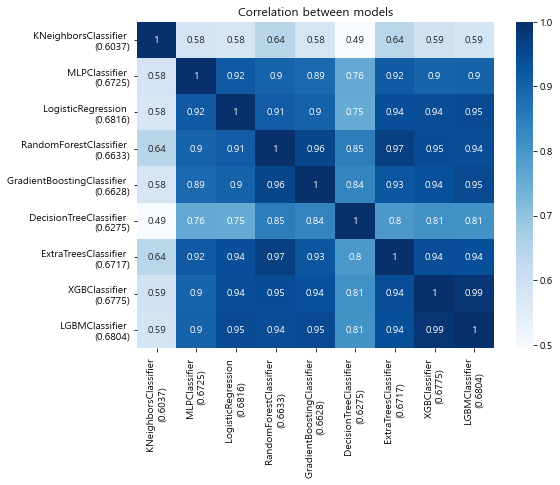

In [44]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [45]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

KNeighborsClassifier \n(0.6037)          0.588212
MLPClassifier \n(0.6725)                 0.845502
LogisticRegression \n(0.6816)            0.862316
RandomForestClassifier \n(0.6633)        0.890140
GradientBoostingClassifier \n(0.6628)    0.872722
DecisionTreeClassifier \n(0.6275)        0.763654
ExtraTreesClassifier \n(0.6717)          0.884346
XGBClassifier \n(0.6775)                 0.882638
LGBMClassifier \n(0.6804)                0.882976
dtype: float64

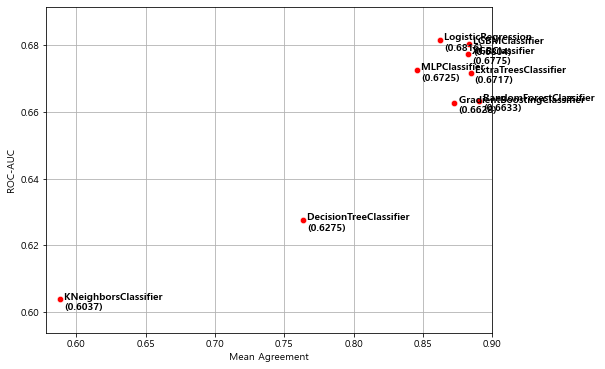

In [46]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

In [47]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier', 
    'DecisionTreeClassifier',
    'ExtraTreesClassifier',
    'XGBClassifier',
    'LGBMClassifier'
    #'SVC'
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [48]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:25<00:00, 48.58s/it]

p=0
LogisticRegression●LGBMClassifier
0.6832510637631577


In [1129]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)    

*Stacking*

In [ ]:
# 2-layer stacking

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.
selected = [
    #'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'ExtraTreesClassifier',
    'DecisionTreeClassifier',
    #'XGBClassifier',
    'LGBMClassifier'
]

estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
stk_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=0), cv=5)

stk_clf.fit(X_train, y_train)
print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1]))  

In [317]:
# 보팅 앙상블
# 각 모델의 최적 파라미터를 기준으로 모델을 설정
# MLPClassifier
model = MLPClassifier(alpha=0.0001, batch_size = 'auto', learning_rate = 'adaptive',
              activation = 'relu', solver = 'sgd',random_state=0)
mlp_model  = model.fit(X_train, y_train)
mlp_model.score(X_dev,y_dev)

# LogisticRegression
model = LogisticRegression(C= 0.1,penalty = 'l2',random_state=0)
lr_model  = model.fit(X_train, y_train)

# RandomForestClassifier
model = RandomForestClassifier(n_estimators = 286,max_depth = 6,min_samples_split=6,min_samples_leaf=1,max_features=23,
                               criterion='entropy',
                               random_state=0)
rfm_model  = model.fit(X_train, y_train)

# GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=473,learning_rate=0.01,
                           max_depth=3,random_state=0)
gbm_model  = model.fit(X_train, y_train)
gbm_model.score(X_dev,y_dev)

# XGBClassifier
model = xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,min_child_weight=3,
                           max_depth=1,random_state=0)
xgb_model  = model.fit(X_train, y_train)

# ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=138,max_depth=4, min_samples_split=6,
                             min_samples_leaf=6,max_features=27,random_state=0)
ett_model  = model.fit(X_train, y_train)

# LGBMClassifier
model = lgb.LGBMClassifier(n_estimators=355,learning_rate=0.01,
                           max_depth=2,min_child_weight=6,random_state=0)
lgb_model  = model.fit(X_train, y_train)

# 각 모델의 정확도를 계산 
lgb_pred = lgb_model.fit(X_train, y_train).predict(X_dev)
rfm_pred = rfm_model.fit(X_train, y_train).predict(X_dev)
xgb_pred = xgb_model.fit(X_train, y_train).predict(X_dev)
ett_pred = ett_model.fit(X_train, y_train).predict(X_dev)
gbm_pred = gbm_model.fit(X_train, y_train).predict(X_dev)
mlp_pred = mlp_model.fit(X_train, y_train).predict(X_dev)
lr_pred = lr_model.fit(X_train, y_train).predict(X_dev)

[18:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [318]:
# 정확도를 가지고 평균 절대 오차를 구한 뒤 가장 작은 값을 가지는 것들을 파악한다.
from sklearn.metrics import mean_absolute_error

print("lgb_pred",mean_absolute_error(y_dev,lgb_pred))
print("rfm_pred",mean_absolute_error(y_dev,rfm_pred))
print("xgb_pred",mean_absolute_error(y_dev,xgb_pred))
print("ett_pred",mean_absolute_error(y_dev,ett_pred))
print("gbm_pred",mean_absolute_error(y_dev,gbm_pred))
print("mlp_pred",mean_absolute_error(y_dev,mlp_pred))
print("lr_pred",mean_absolute_error(y_dev,lr_pred))

lgb_pred 0.35333333333333333
rfm_pred 0.3495238095238095
xgb_pred 0.34
ett_pred 0.34476190476190477
gbm_pred 0.3495238095238095
mlp_pred 0.3647619047619048
lr_pred 0.34


In [319]:
# 파악 후 낮은 것 중 3개를 가져오고 낮을수록 가중치를 많이 주어 보팅앙상블을 실시했다.
voting = VotingClassifier(estimators=[('xgb', xgb_model),('ETT', ett_model),
                                      ('LR', lr_model)],voting='soft',weights=[4,3,4])
voting.fit(X_train, y_train)
print(roc_auc_score(y_dev, voting.predict_proba(X_dev)[:,1])) 
voting.predict_proba(X_test)[:,1]

[18:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6798493703539875


array([0.4437231 , 0.1680172 , 0.21101994, ..., 0.50672024, 0.43777121,
       0.51647264])

### 6. Deployment

In [ ]:
# Averaging ensemble로 예측한 submission: (결과) 0.71959
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv('submission_avg.csv', index=False)

In [320]:
# Stacking ensemble로 예측한 submission: (결과) 0.71928
pd.DataFrame({'cust_id': test_id, 'gender': stk_clf.predict_proba(X_test)[:,1]}).to_csv('submission_stk.csv', index=False)

# 단일 모델로 성능이 가장 높은 Logistic Regression으로 예측한 submission: (결과) 0.71403

In [1137]:
# Weight_voting (soft)을 적용한 submission
pd.DataFrame({'cust_id': test_id, 'gender': voting.predict_proba(X_test)[:,1]}).to_csv('submission_voting.csv', index=False)

<font color="#CC3D3D"><p>
# End